## Importering av nødvendige biblioteker

In [53]:
import pandas as pd 
import numpy as np 
from simulation import simulation_erlang as sim
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from optimization import optimization as opt
from pyworkforce.queuing import MultiErlangC
from pyworkforce.queuing import ErlangC

## Optimization for Staffing

In [117]:
def datalast_behandling(path: str) -> pd.DataFrame:
    fin_hf_med = pd.read_excel(path, sheet_name = "medisinsk hammerfest")
    fin_hf_kir_ort = pd.read_excel(path, sheet_name = "kirurgisk hammerfest")

    # post kolonne
    fin_hf_med["post"] = "medisinsk"
    fin_hf_kir_ort["post"] = "kirurgisk"

    # merge and order datasets
    fin_data = pd.concat([fin_hf_med, fin_hf_kir_ort], axis=0).sort_values("Dato").reset_index()
    fin_data.drop(["index"], axis=1, inplace=True)
    fin_data['helg'] = fin_data['Dato'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
    return fin_data

def opt_dataset(dataset: pd.DataFrame, post: str, weekend: bool = False, predictions: bool = False, year: int = 2024) -> pd.DataFrame:
    if post == "medisinsk":
        df_fin = dataset[dataset["post"] == "medisinsk"]
    elif post == "kirurgisk":
        df_fin = dataset[dataset["post"] == "kirurgisk"]
    
    if weekend == True:
        df_fin = df_fin[df_fin["helg"] == 1]
    else:
        df_fin = df_fin[df_fin["helg"] == 0]

    if predictions == True:
        df_fin = df_fin[df_fin["År"] == 2025]
    else:
        df_fin = df_fin[df_fin["År"] == year]
    
    df_fin = df_fin.reset_index()
    df_fin.drop(["index"], axis=1, inplace=True)
    df_fin = df_fin[["Dato", "Antall inn på post", "Belegg pr. dag"]]

    return df_fin

def staff_opt_plot(staff_allocated: list):
    # Plot staffing requirements
    plt.figure(figsize=(10, 6))
    plt.plot(staff_allocated, marker='o', color='g', linestyle='-')
    plt.title('Staffing Requirements for Post at Hammerfest')
    plt.xlabel('Day')
    plt.ylabel('Number of Staff Required')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [118]:
path = "./data/fin_hf_datagrunnlag.xlsx"
fin_data = datalast_behandling(path)
data = opt_dataset(fin_data, "medisinsk", year=2023)


df_index = data.Dato
demand = data["Antall inn på post"] + round(data["Belegg pr. dag"])
MaxStaff = 30
PPS = 4
availability = 20
ServiceLevel = 0.8

In [119]:
model = opt.labor_scheduling(df_index, demand, MaxStaff, PPS, availability, ServiceLevel)
result, status, obj, staff_allocated = opt.optimize_staffing(model)
data["staff_allocated"] = staff_allocated
display(data)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write C:\Users\Consumer\AppData\Local\Temp\tmp9hmantnf.glpk.raw --wglp
 C:\Users\Consumer\AppData\Local\Temp\tmp3hlqhvbh.glpk.glp --cpxlp C:\Users\Consumer\AppData\Local\Temp\tmpgr_d8pnj.pyomo.lp
Reading problem data from 'C:\Users\Consumer\AppData\Local\Temp\tmpgr_d8pnj.pyomo.lp'...
780 rows, 260 columns, 780 non-zeros
260 integer variables, none of which are binary
3910 lines were read
Writing problem data to 'C:\Users\Consumer\AppData\Local\Temp\tmp3hlqhvbh.glpk.glp'...
3123 lines were written
GLPK Integer Optimizer 5.0
780 rows, 260 columns, 780 non-zeros
260 integer variables, none of which are binary
Preprocessing...
Objective value =   1.867000000e+03
INTEGER OPTIMAL SOLUTION FOUND BY MIP PREPROCESSOR
Time used:   0.0 secs
Memory used: 0.4 Mb (395764 bytes)
Writing MIP solution to 'C:\Users\Consumer\AppData\Local\Temp\tmp9hmantnf.glpk.raw'...
1049 lines were written


,Dato,Antall inn på post,Belegg pr. dag,staff_allocated
0,2023-01-02,10,27.208333,8.0
1,2023-01-03,7,25.166667,7.0
2,2023-01-04,16,25.458333,9.0
3,2023-01-05,6,28.875000,7.0
4,2023-01-06,6,24.916667,7.0
...,...,...,...,...
255,2023-12-25,8,17.875000,6.0
256,2023-12-26,6,24.750000,7.0
257,2023-12-27,14,26.250000,8.0
258,2023-12-28,11,24.500000,8.0


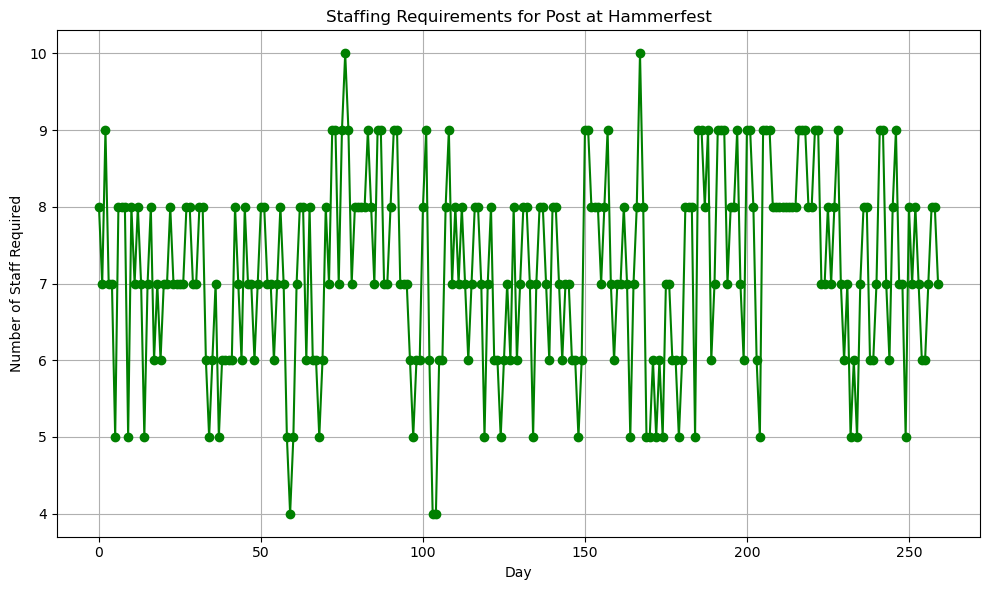

In [123]:
staff_opt_plot(staff_allocated)